<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/Multiple_Instance_Learning_for_Classification_of_Dementia_in_Brain_MRI_using_Oaisis_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset Preparation

In [4]:
# Install dependencies
!pip install torch torchvision scikit-learn numpy pillow opencv-python matplotlib seaborn --quiet

import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

# Extract the ZIP file
zip_path = '/content/oaisis.zip'
extract_dir = '/content/oasis_data/'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_path} to {extract_dir}")

# Inspect the extracted directory structure
print("Directory structure after extraction:")
!ls -R /content/oasis_data/

# Custom Dataset Class for OASIS
class OASISDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        class_mapping = {
            'Mild Dementia': 0,
            'Moderate Dementia': 1,
            'Non Demented': 2,
            'Very mild Dementia': 3
        }

        for class_name, label in class_mapping.items():
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith('.jpg'):
                        img_path = os.path.join(class_dir, img_file)
                        self.images.append(img_path)
                        self.labels.append(label)
            else:
                print(f"Warning: Directory {class_dir} not found.")
        if not self.images:
            print("No .jpg files found in any class directories.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            if self.transform:
                img = self.transform(img)
            return torch.from_numpy(img).float().unsqueeze(0), label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

# Preprocessing Function
def preprocess_img(img):
    try:
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)  # Resize to 128x128
        img = img / 255.0  # Normalize to [0, 1]
        return img
    except Exception as e:
        print(f"Preprocessing error: {e}")
        return None

# Load and Split the Dataset
data_dir = os.path.join(extract_dir, 'Data')  # Adjust this based on the extracted structure
dataset = OASISDataset(data_dir, transform=preprocess_img)
valid_data = []
for i in range(len(dataset)):
    img, label = dataset[i]
    if img is not None and label is not None:
        valid_data.append((img, label))
    else:
        print(f"Skipping invalid data at index {i}")

train_idx, val_idx = train_test_split(range(len(valid_data)), test_size=0.2, random_state=42)
train_loader = DataLoader([valid_data[i] for i in train_idx], batch_size=12, shuffle=True)
val_loader = DataLoader([valid_data[i] for i in val_idx], batch_size=12, shuffle=False)

print(f"Loaded {len(valid_data)} valid images, split into {len(train_idx)} training and {len(val_idx)} validation samples.")

Streaming output truncated to the last 5000 lines.
OAS1_0042_MR1_mpr-2_134.jpg  OAS1_0247_MR1_mpr-4_104.jpg
OAS1_0042_MR1_mpr-2_135.jpg  OAS1_0247_MR1_mpr-4_105.jpg
OAS1_0042_MR1_mpr-2_136.jpg  OAS1_0247_MR1_mpr-4_106.jpg
OAS1_0042_MR1_mpr-2_137.jpg  OAS1_0247_MR1_mpr-4_107.jpg
OAS1_0042_MR1_mpr-2_138.jpg  OAS1_0247_MR1_mpr-4_108.jpg
OAS1_0042_MR1_mpr-2_139.jpg  OAS1_0247_MR1_mpr-4_109.jpg
OAS1_0042_MR1_mpr-2_140.jpg  OAS1_0247_MR1_mpr-4_110.jpg
OAS1_0042_MR1_mpr-2_141.jpg  OAS1_0247_MR1_mpr-4_111.jpg
OAS1_0042_MR1_mpr-2_142.jpg  OAS1_0247_MR1_mpr-4_112.jpg
OAS1_0042_MR1_mpr-2_143.jpg  OAS1_0247_MR1_mpr-4_113.jpg
OAS1_0042_MR1_mpr-2_144.jpg  OAS1_0247_MR1_mpr-4_114.jpg
OAS1_0042_MR1_mpr-2_145.jpg  OAS1_0247_MR1_mpr-4_115.jpg
OAS1_0042_MR1_mpr-2_146.jpg  OAS1_0247_MR1_mpr-4_116.jpg
OAS1_0042_MR1_mpr-2_147.jpg  OAS1_0247_MR1_mpr-4_117.jpg
OAS1_0042_MR1_mpr-2_148.jpg  OAS1_0247_MR1_mpr-4_118.jpg
OAS1_0042_MR1_mpr-2_149.jpg  OAS1_0247_MR1_mpr-4_119.jpg
OAS1_0042_MR1_mpr-2_150.jpg  OAS1_024

#Patch Extraction Using Discriminative Probabilities

In [5]:
# Function to Extract Patches and Compute Discriminative Probabilities
def extract_patches(img, patch_size=16, stride=8, spatial_threshold=16, num_patches=10):
    """
    Extract patches from an image and select top discriminative patches.

    Args:
        img (torch.Tensor): Image tensor of shape (1, H, W)
        patch_size (int): Size of the square patch
        stride (int): Stride for patch extraction
        spatial_threshold (int): Minimum distance between patch centers
        num_patches (int): Number of patches to extract

    Returns:
        patches (list): List of selected patches (torch.Tensor)
        centers (list): List of (x, y) coordinates of patch centers
    """
    img = img.squeeze(0).numpy()  # Convert to numpy (H, W)
    h, w = img.shape
    patches = []
    centers = []
    variances = []

    # Extract all possible patches
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            # Compute variance as a proxy for discriminative probability
            variance = np.var(patch)
            patches.append(patch)
            centers.append((x + patch_size // 2, y + patch_size // 2))
            variances.append(variance)

    # Sort patches by variance (descending)
    indices = np.argsort(variances)[::-1]
    selected_patches = []
    selected_centers = []

    # Select patches with spatial constraint
    for idx in indices:
        if len(selected_patches) >= num_patches:
            break
        center = centers[idx]
        # Check spatial distance from already selected patches
        too_close = False
        for selected_center in selected_centers:
            dist = np.sqrt((center[0] - selected_center[0])**2 + (center[1] - selected_center[1])**2)
            if dist < spatial_threshold:
                too_close = True
                break
        if not too_close:
            selected_patches.append(torch.tensor(patches[idx]).float())
            selected_centers.append(center)

    return selected_patches, selected_centers

# Test Patch Extraction on a Sample Image
sample_img, sample_label = valid_data[0]
patches, centers = extract_patches(sample_img, patch_size=16, stride=8, spatial_threshold=16, num_patches=10)
print(f"Extracted {len(patches)} patches from sample image.")

Extracted 10 patches from sample image.


#Construct Graphs for Each Image (Bag)

In [6]:
# Function to Construct a Graph (Distance Matrix) from Patches
def construct_graph(patches):
    """
    Construct a graph as a distance matrix based on patch intensities.

    Args:
        patches (list): List of patch tensors

    Returns:
        W (np.ndarray): Distance matrix (K x K)
    """
    K = len(patches)
    W = np.zeros((K, K))
    for i in range(K):
        # Convert patch i to NumPy array
        patch_i = patches[i].numpy().flatten()
        for j in range(K):
            if i != j:
                # Convert patch j to NumPy array
                patch_j = patches[j].numpy().flatten()
                # Compute squared Euclidean distance between patches
                diff = patch_i - patch_j
                W[i, j] = np.sum(diff ** 2)
    return W

# Create a Bag (Image) with Patches and Graph
class ImageBag:
    def __init__(self, image, label, num_patches=10):
        self.patches, self.centers = extract_patches(image, num_patches=num_patches)
        self.graph = construct_graph(self.patches)  # Distance matrix
        self.label = label

# Create Bags for All Images
train_bags = [ImageBag(img, label) for img, label in [valid_data[i] for i in train_idx]]
val_bags = [ImageBag(img, label) for img, label in [valid_data[i] for i in val_idx]]
print(f"Created {len(train_bags)} training bags and {len(val_bags)} validation bags.")

Created 69149 training bags and 17288 validation bags.


#Define a Graph Kernel and Train a Classifier

In [7]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel

# Compute Graph Kernel (Simplified) with Subset
def graph_kernel(bags, max_bags=None):
    """
    Compute a kernel matrix for a list of bags using their graphs.

    Args:
        bags (list): List of ImageBag objects
        max_bags (int, optional): Maximum number of bags to process (for memory optimization)

    Returns:
        K (np.ndarray): Kernel matrix (N x N)
    """
    N = len(bags) if max_bags is None else min(max_bags, len(bags))
    bags_subset = bags[:N]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            # Compute Frobenius norm of the difference between distance matrices
            diff = bags_subset[i].graph - bags_subset[j].graph
            K[i, j] = np.exp(-np.linalg.norm(diff, 'fro')**2 / (2 * 1.0**2))  # RBF-like kernel
    return K

# Prepare Training Data
train_labels = [bag.label for bag in train_bags]
val_labels = [bag.label for bag in val_bags]

# Use a subset of the data for testing (e.g., first 50 bags)
max_bags = 50
train_subset = train_bags[:max_bags]
val_subset = val_bags[:max_bags]
train_labels_subset = train_labels[:max_bags]
val_labels_subset = val_labels[:max_bags]

# Compute Kernel Matrices with Subset
train_kernel = graph_kernel(train_subset, max_bags)
val_kernel = graph_kernel(val_subset, max_bags)

# Train SVM with Precomputed Kernel
svm = SVC(kernel='precomputed')
svm.fit(train_kernel, train_labels_subset)
print("SVM training completed with subset.")

SVM training completed with subset.


#Evaluate the Model (Confusion Matrix, Accuracy, Validation Figure)

Accuracy on validation subset: 64.00%


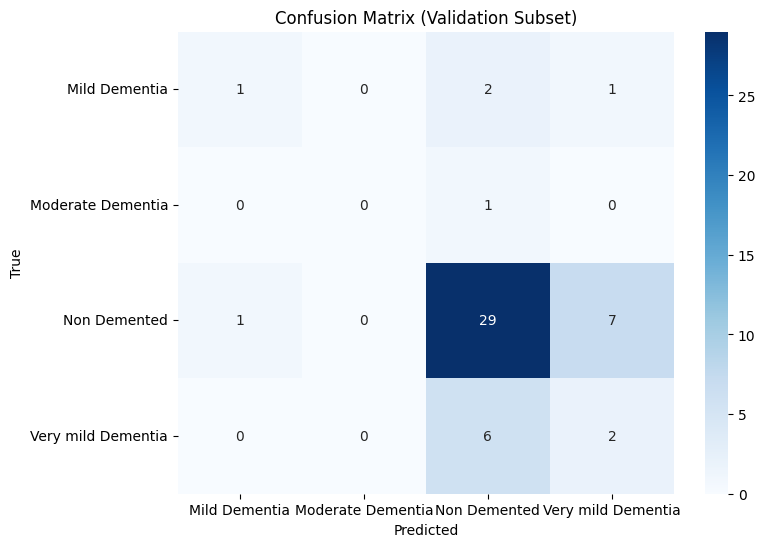

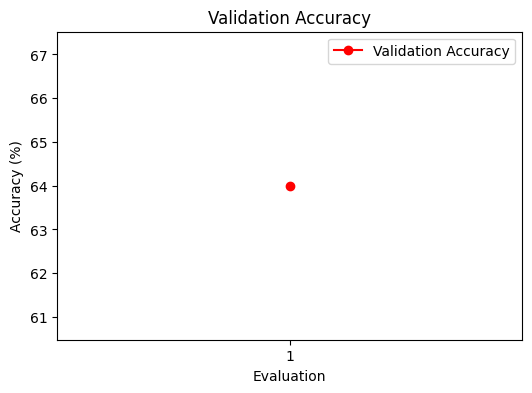

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate on Validation Set using the Subset
val_preds = svm.predict(val_kernel)
val_accuracy = accuracy_score(val_labels_subset, val_preds) * 100  # Use val_labels_subset instead of val_labels
print(f'Accuracy on validation subset: {val_accuracy:.2f}%')

# Compute and Plot Confusion Matrix
class_names = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
cm = confusion_matrix(val_labels_subset, val_preds)  # Use val_labels_subset
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Validation Subset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot Validation Accuracy (Single Point)
epochs = [1]
val_accuracies = [val_accuracy]

plt.figure(figsize=(6, 4))
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Evaluation')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.show()